# Solutions to (some of) the homework problems

I strongly advise you not to look at the solutions until you have tried really hard to solve the problems by yourself.

In the solution to the telescope slew problem, we use numpy arrays as much as possible to simplify the code. This also makes it very efficient (in terms of execution time), which isn't an issue in this example, but could be if you had to calculate billions of distances.

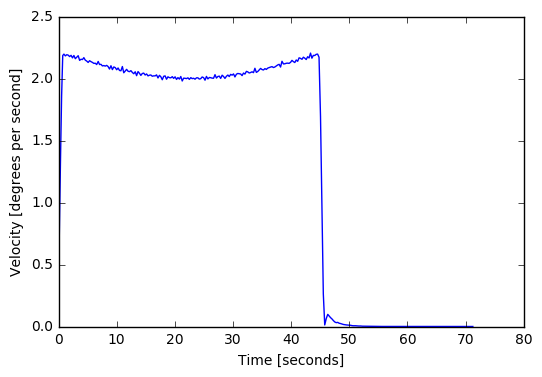

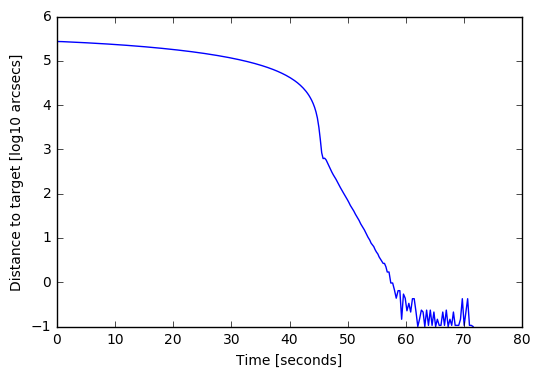

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get the slew data from a URL. The columns are time in seconds,
# then altitude and azimuth in degrees. Warning: numpy.genfromtxt()
# caches the data that it reads from the web, and it won't pick up
# changes that are made later to the web file.

arr = np.genfromtxt('http://mcba11.phys.unsw.edu.au/~mcba/phys3112/slew99.dat')

# Convert columns 1 and 2 (alt/az) from degrees to radians.

arr[:,1:3] *= np.pi / 180.0

# Find the great circle distance between neighbouring rows, using
# the haversine formula (see wikipedia: "great circle distance").
# The haversine formula performs well for small angles. "ds" will
# have one less element than the number of rows in the original array.

ds = 2 * np.arcsin((np.sin((arr[1:,2] - arr[:-1,2])/2)**2 + np.cos(arr[1:,2])*np.cos(arr[:-1,2])*np.sin((arr[1:,1] - arr[:-1,1])/2)**2)**0.5)

# Calculate the velocity in degrees per second along the direction of
# motion.

velocity = (ds / (arr[1:,0] - arr[:-1,0])) * 180.0 / np.pi

# Calculate the great circle distance to the target position,
# assumed to be the last row in the data.

distance = 2 * np.arcsin((np.sin((arr[-1,2] - arr[:,2])/2)**2 + np.cos(arr[-1,2])*np.cos(arr[:,2])*np.sin((arr[-1,1] - arr[:,1])/2)**2)**0.5)

# Convert radians to arcseconds.

distance *= 3600 * 180 / np.pi

# Plot results.

plt.plot(arr[:-1,0], velocity)
plt.xlabel("Time [seconds]")
plt.ylabel("Velocity [degrees per second]")
plt.show()

# Since we are going to take the logarithm of the distance,
# let's make sure that we don't have very small or zero distances
# by setting any value less than 0.1 arcseconds to 0.1.
#
# Here is one way to do this, using numpy array operations, and using
# the fact that a logical operator such as "<" returns 0 or 1.
#
# distance += (0.1 - distance) * (distance < 0.1)

# Here is another way, using numpy.full_like() to create an array
# of the same shape as "distance", filled with the scalar value 0.1. We
# can then use numpy.maximum() to clip "distance". I like this
# approach the best.

distance = np.maximum(distance, np.full_like(distance, 0.1))

# An alternative approach is to use numpy.clip to do the work, such
# as in this commented-out piece of code:
#
# np.clip(distance, 0.1, 100000, out=distance)

plt.plot(arr[:,0], np.log10(distance))
plt.xlabel("Time [seconds]")
plt.ylabel("Distance to target [log10 arcsecs]")
plt.show()


You can see in the above plots that the telescope initially accelerates to a maximum slew speed of about 2 degrees per second, it then switches to a different algorithm when it is about 10 arcminutes from the final position, and then approaches the final position exponentially (hence the straight line in the log/lin plot). The noise between 60 and 70 seconds gives an idea of the tracking precision of the telescope mounting.

# Three body gravitation

The next example is a 3D visualization of three bodies interacting under gravity. You need the `vpython` module to run this. The choice of initial conditions and time step are crucial to see interesting behaviour. When the simulation is running, you can interact with the 3D view using a touchscreen, or right-click and move the mouse. Use `Kernel->Restart` to stop the simulation.

In [ ]:
# Example of star orbits, based on a binary star example
# from http://www.glowscript.org

import numpy as np
import scipy.constants
from vpython import *

scene = canvas()
scene.forward = vector(0,-.3,-1)

G = scipy.constants.physical_constants['Newtonian constant of gravitation'][0]

# Define three stars, giving their initial positions, 
# radii, masses, and momenta.

star1 = sphere(pos = vector(0,0,0), radius = 2e10, 
               color = color.red, make_trail = True,
               interval = 10, retain = 50)
star1.mass = 3e30
star1.p = vector(0, 0, -1e4) * star1.mass

star2 = sphere(pos = vector(4e11,0,0), radius = 1e10, 
               color = color.yellow, make_trail = True, 
               interval = 10, retain = 50)
star2.mass = 5e30
star2.p = vector(-1e4, 0, 0) * star2.mass

star3 = sphere(pos = vector(4e11, 3e11,0), radius = 0.5e10, 
               color = color.green, make_trail = True, 
               interval = 10, retain = 50)
star3.mass = 4e30
star3.p = vector(0,-1e4,0) * star3.mass

dt = 1e4 # time increment per loop in seconds

while True:
    rate(200)

    # Relative positions of the stars from each other.
    
    r12 = star1.pos - star2.pos
    r13 = star1.pos - star3.pos
    r23 = star2.pos - star3.pos
    
    # All the forces.
    
    F12 = G * star1.mass * star2.mass * r12.hat / mag2(r12)
    F13 = G * star1.mass * star3.mass * r13.hat / mag2(r13)
    F23 = G * star2.mass * star3.mass * r23.hat / mag2(r23)
    
    # Update the momenta of the stars. Note conservation of momentum.
    
    star1.p = star1.p + (-F12 - F13)*dt
    star2.p = star2.p + (+F12 - F23)*dt
    star3.p = star3.p + (+F13 + F23)*dt
    
    # Finally, update the positions.
    
    star1.pos = star1.pos + (star1.p/star1.mass) * dt
    star2.pos = star2.pos + (star2.p/star2.mass) * dt
    star3.pos = star3.pos + (star3.p/star3.mass) * dt